In [ ]:
from qwenaug.model import download_qwen_weights, load_qwen_image_edit
import torch
download_qwen_weights('weights')
pipeline = load_qwen_image_edit()

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/254M [00:00<?, ?B/s]

Qwen_Image_Edit-Q8_0.gguf:   0%|          | 0.00/21.8G [00:00<?, ?B/s]

# Get COCO Dataset

In [ ]:
from pycocotools.coco import COCO
coco = COCO('annotations/instances_train2017.json')

img_id = 96705
img = coco.imgs[img_id]

loading annotations into memory...
Done (t=11.19s)
creating index...
index created!


http://farm3.staticflickr.com/2654/3777250962_6a9a281713_z.jpg


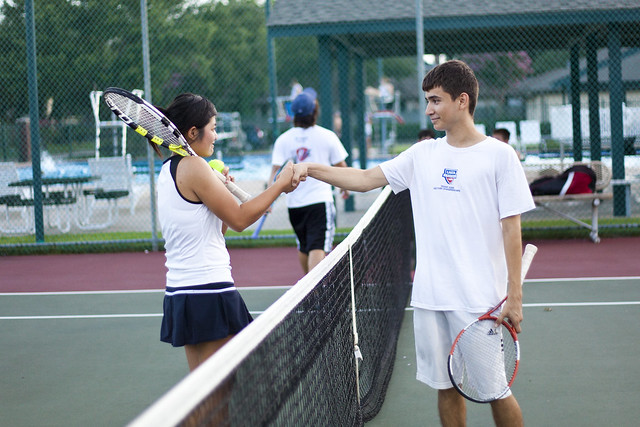

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from diffusers.utils import load_image

print(img['flickr_url'])
image = load_image(img['flickr_url'])

display(image)

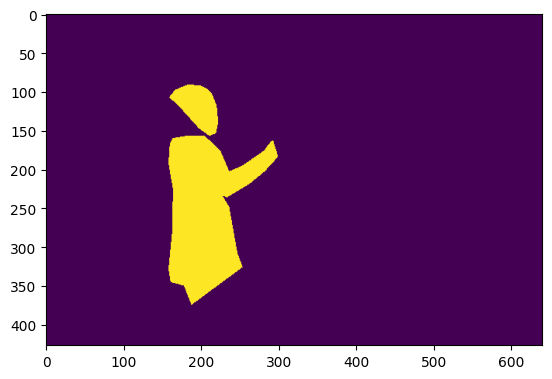

In [ ]:
cat_ids = [] # insert your cat ids here
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
# anns = coco.loadAnns(anns_ids)
mask = coco.annToMask(anns[0])
plt.imshow(mask)

Base image shape: (640, 430)
Overlay image shape: (256, 256)


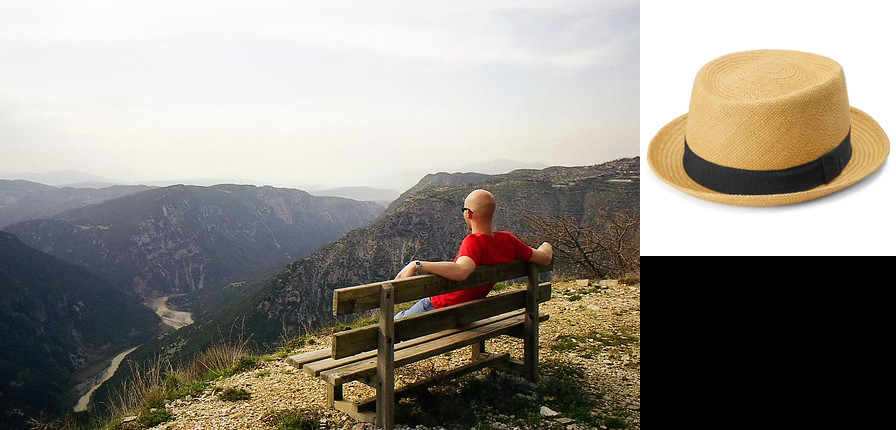

In [19]:
base_image = load_image(img['flickr_url'])
print(f"Base image shape: {base_image.width, base_image.height}")
overlay_image = load_image('examples/images/hat.png')
print(f"Overlay image shape: {overlay_image.width, overlay_image.height}")
# mask_image=Image.open(pl.Path(input_path).parent.joinpath(input_path.stem + "_mask" + input_path.suffix))

# Combine base_image and overlay_image
width = base_image.width + overlay_image.width
height = max(base_image.height, overlay_image.height)
# print(base_image.width, base_image.height, overlay_image.width, overlay_image.height, width, height)
full_image = Image.new("RGB", (width, height))
full_image.paste(base_image, (0, 0))
# TODO: Add padding, center overlay
full_image.paste(overlay_image, (base_image.width, 0))
display(full_image)

In [ ]:
prompt = 'Add the hat on the person'
print(prompt)
# Compose base image and overlay

inputs = {
    "image": full_image,
    "prompt": prompt,
    "true_cfg_scale": 4.0,
    "negative_prompt": " ",
    "num_inference_steps": 50,
    "width": full_image.width,
    "height": full_image.height,
    # "mask_image": full_mask
}

with torch.inference_mode():
    output = pipeline(**inputs)
    output_image = output.images[0]
    output_image = output_image.crop(box=(0,0,base_image.width, base_image.height))
    output_image.save(f'output/{img_id}.jpg')
    # print("image saved at", output_path)

In [ ]:
prompt = "Put the text \"{}\" on the person."
text = "Banana"
import time

inputs = {
    "image": image,
    "prompt": prompt.format(text),
    "generator": torch.manual_seed(0),
    "true_cfg_scale": 4.0,
    "negative_prompt": " ",
    "num_inference_steps": 50,
}

start_time = time.time()
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

with torch.inference_mode():
    output = pipeline(**inputs)

elapsed = time.time() - start_time
peak_vram = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0.0

output_image = output.images[0]
output_image.save(f'output/{img_id}.jpg')
print(f"Processed {f'output/{img_id}.jpg'} in {elapsed:.2f}s. Peak VRAM: {peak_vram:.2f} MiB. image saved in {f'output/{img_id}.jpg'}")

  0%|          | 0/50 [00:00<?, ?it/s]

Processed output/410107.jpg in 164.67s. Peak VRAM: 22085.41 MiB. image saved in output/410107.jpg


In [24]:
import json
import csv

with open('examples/annotations/instances_train2017.json') as f:   
    anns = json.load(f)

# csv_path = "examples/images/input.csv"
# d = {}
# with open(csv_path, mode="r") as file:
#     reader = csv.DictReader(file)



In [25]:
from pycocotools.coco import COCO
d = {}
img_ids = [
581262,
113801,
418772,
465143,   
233527,   
305895,   
305895,
353652,   
410107,
]
coco = COCO('examples/annotations/instances_train2017.json')

for k in ['info', 'licenses', 'images', 'annotations', 'categories']:
    d[k] = anns[k]
for img_id in img_ids:
    img = coco.imgs.get(img_id)
    anns_ids = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    d['images'] = img
    d['annotations'] = anns



loading annotations into memory...
Done (t=11.29s)
creating index...
index created!


In [ ]:
with open('examples/annotations/reduced_set.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

{'license': 2,
 'file_name': '000000410107.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000410107.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-23 03:06:28',
 'flickr_url': 'http://farm3.staticflickr.com/2654/3777250962_6a9a281713_z.jpg',
 'id': 410107}